In [1]:
# 1. importing Necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.impute import SimpleImputer
from  sklearn.preprocessing import StandardScaler,OneHotEncoder

In [4]:
#2. Loading Dataset
df=pd.read_csv("Exohabit_dataset.csv", comment='#')
df=df[df['default_flag']==1].copy()

C:\Users\DELL\AppData\Local\Temp\ipykernel_4808\1367262124.py:2: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("Exohabit_dataset.csv", comment='#')


In [63]:
#neccessary columns
necce_fea={
    'pl_rade': 'planet_radius',
    'pl_bmasse':'planet_mass',
    'pl_orbper': 'orbital_period',
    'pl_orbsmax': 'semi_major_axis',
    'pl_eqt': 'equilibrium_temperature',
    'st_teff': 'star_temperature',
    'st_lum': 'star_luminosity',
    'st_met': 'star_metallicity',
    'st_spectype': 'star_type',
    'pl_insol':'Insolation_Flux'
}

df_necce=df[list(necce_fea.keys())].copy()


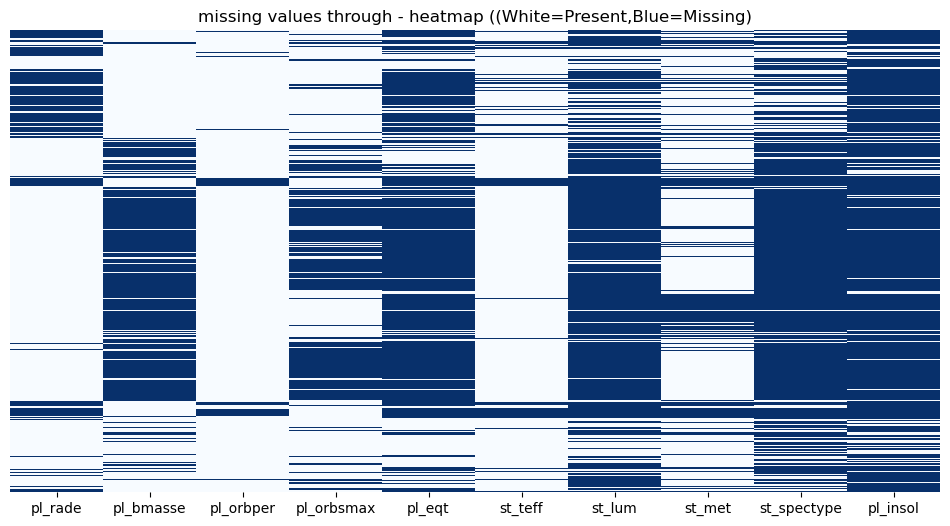

In [64]:
# 3. missing values through - heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df_necce.isnull(),cbar=False,cmap='Blues',yticklabels=False)
plt.title('missing values through - heatmap ((White=Present,Blue=Missing)')
plt.show()


In [65]:
#4. handling missing data and median, mode
col = [
    'pl_rade',
    'pl_bmasse',
    'pl_orbper',
    'pl_orbsmax',
    'pl_eqt',
    'st_teff',
    'st_lum',
    'st_met',
    'pl_insol'
]

col2 = ['st_spectype']

med=SimpleImputer(strategy='median')
mod=SimpleImputer(strategy='most_frequent')
df_necce[col]=med.fit_transform(df_necce[col])
df_necce[col2]=mod.fit_transform(df_necce[col2])


In [67]:
#5. Removal of outliers
out1 = (
    (df_necce['pl_rade'] <= 0) |
    (df_necce['pl_bmasse']<= 0) |
    (df_necce['st_teff'] <= 0)
)

df_necce = df_necce[~out1]


In [68]:
out2=df_necce['pl_rade']>50
df_necce=df_necce[~out2]

In [69]:
# 6. Feature Engineering

rade = df_necce['pl_rade'] <= 2.0
insol = df_necce['pl_insol'].between(0.2, 1.5)
eqt = df_necce['pl_eqt'].between(180, 310)

df_necce['Target_Habitability'] = ((rade) & (insol | eqt)).astype(int)


In [70]:
df_necce['Habitability_Score'] = (
    np.exp(-np.abs(df_necce['pl_rade'] - 1.0)) +
    np.exp(-np.abs((df_necce['pl_eqt'] - 288.0) / 288.0)) +
    np.exp(-np.abs(df_necce['pl_insol'] - 1.0))
) / 3.0


In [71]:
df_necce['Steller_Compatibility']=np.exp(-np.abs((df_necce['st_teff']-5778.0)/1000.0))

In [72]:
df_necce['Orbital_Stability_Score'] = np.log1p(
    df_necce['pl_orbper'] * df_necce['pl_orbsmax']
)


In [73]:
df_necce['Star_Type'] = (
    df_necce['st_spectype']
    .astype(str)
    .str[0]
    .str.upper()
)

upper=['O','B','A','F','G','K','M']
df_necce['Star_Type'].apply(lambda x: x if x in upper else 'Other')


0        G
4        G
7        K
9        G
17       G
        ..
39192    F
39198    F
39204    F
39208    G
39211    K
Name: Star_Type, Length: 6064, dtype: object

In [74]:
#One-Hot encoding
one_hot_encoding=OneHotEncoder(sparse_output=False,handle_unknown='ignore')
encode_star=one_hot_encoding.fit_transform(df_necce[['Star_Type']])
encode_col=one_hot_encoding.get_feature_names_out(['Star_Type'])

df_encode_star=pd.DataFrame(encode_star,columns=encode_col,index=df_necce.index)

df_tog=pd.concat([df_necce,df_encode_star],axis=1)
df_tog.drop(columns=['st_spectype','Star_Type'],inplace=True)

In [75]:
#7. Feature Scaling  - Standardization
# Columns to scale
df_tog['Stellar_Compatibility'] = np.exp(
    -np.abs((df_tog['st_teff'] - 5778.0) / 1000.0)
)

scalingCol = col + [
    'Habitability_Score',
    'Stellar_Compatibility',
    'Orbital_Stability_Score'
]

scaler = StandardScaler()
df_tog[scalingCol] = scaler.fit_transform(df_tog[scalingCol])


In [78]:
#pre-processed dataset
df_tog.to_csv('pre-processedd.csv',index=False)


In [79]:
df_tog.shape

(6064, 24)